# Word2vec + K-means

First, we need to create word vectors. For simplicity, we will use a pretrained Word2Vec model
with Ukrainian words-vectors, each of which has a dimension of 300.

This sample of word vectors was created on the basis of neews feed. We chose the lematized version of this model because we already have our sample, which we processed in the previous part, which would fit perfectly here.

The model can be found on [this website](https://lang.org.ua/uk/models/).

In [1]:
import numpy as np
import pandas as pd
import pickle
import gensim, logging
import gensim.models.keyedvectors as word2vec
import matplotlib.pyplot as plt

%matplotlib inline

Also let's write a style for alignment in the middle of all graphs, images, etc:

# Data

In [144]:
# Importing prepared dataset
import pickle
input = open('my_corpus-21-sql.pql', 'rb')
obj = pickle.load(input)
input.close()

txt = obj['txt']
corpus = obj['corpus']
words_list = obj['words_list']
all_words = obj['all_words']
print(corpus[1])

світовий пандемія принести невизначеність вимушений реагувати надшвидко маючи право помилка бізнес винаходити модель благодійний адаптуватися кризовий умова пропонуючи підхід рішення проєкт травень директорка виступити віртуальний саміт благодійництво тема фандрайзинг специфіка ковіднога долучитися дискусіїй секція благодійник бізнес адаптивність криза запрошувати прийняти саміт участь безкоштовний реєстрація посилання


In [145]:
txt.reset_index(drop=True,inplace=True)

In [77]:
print("Number of documents:", len(corpus), len(words_list))

Number of documents: 2852 2852


# W2V

Now we will load our word2vec model. 

This may take some time, as the model contains 174 311  words, so we will get a 174 311 x 300 embedding matrix that contains all the values of the word vectors.

In [3]:
model = word2vec.KeyedVectors.load_word2vec_format('ubercorpus.lowercased.lemmatized.word2vec.300d.txt', binary=False)

Now let's get a list of all the words from our dictionary:

In [4]:
words = list(model.key_to_index)

Just to make sure everything is loaded correctly, we can look at the dimensions of the dictionary list and the embedding matrix:

In [80]:
print(words[:50], "\n\nTotal words:", len(words), "\n\nWord-Vectors shape:", model.vectors.shape)

['в', 'на', 'у', 'і', 'з', 'що', 'не', 'бути', 'до', 'за', 'та', 'це', 'україна', 'який', 'як', 'про', 'рік', 'а', 'він', 'для', 'від', 'свій', 'вони', 'його', 'цей', 'також', 'я', 'ми', 'той', 'й', 'категорія', 'один', 'мати', 'час', 'такий', 'із', 'але', 'могти', 'під', 'рок', 'президент', 'по', 'те', 'вона', 'після', 'сказати', 'країна', 'український', 'інший', 'так'] 

Total words: 325250 

Word-Vectors shape: (325250, 300)


We can also find a word like "лікар" in our word list and then access the corresponding vector through the embedding matrix:

In [81]:
print(model['лікар'])

[ 1.51717  -0.134897  0.224948 -0.682988  0.255189 -1.154029 -0.301166
 -0.779664 -0.83877  -0.701848  1.322624  0.304473 -0.70041  -1.429774
 -2.201554  2.123548 -2.553981 -0.477305  0.890671 -2.159831 -1.528332
 -1.461742 -1.884233  0.596946  3.100615  0.71978   0.257926  1.301619
 -1.058888  1.544139 -0.416671 -0.949557  0.857162 -1.498397 -1.485203
 -1.329037 -1.622431  1.787814  2.138087 -1.843644  0.675296  3.028688
 -0.944908 -2.709706 -0.748897  1.443689 -2.944499 -0.207586  1.658878
  0.52291  -3.942196 -0.579682 -0.725423 -2.306848 -2.240943 -1.465646
  0.864063  1.049615  1.267616  2.492405 -1.081743 -1.288536 -0.131866
 -1.36518  -1.635456 -2.145586  0.500408  0.072643  1.684566  2.661417
  0.263487 -1.231238 -1.580362  0.290863  0.982332  0.791808  1.459162
 -0.50413   2.97762  -1.652422 -0.518947  1.336689  2.064064  0.153861
  1.154642 -0.11887  -0.166842  0.047205 -3.389652  0.447788  1.36971
 -0.899343  0.21818   2.630816 -0.197572 -1.588387  1.554321 -1.432677
  1.450

# Word Average Embedding Model

Let's start analyzing our vectors. Our first approach will be the **word average embedding model**. 

The essence of this naive approach is to take the average of all word vectors from a sentence to get one 300-dimensional vector that represents the tone of the whole sentence that we feed the model and try to get some quick result.

We didn't have to put a try/except, but even though I cleaned up our sample, there were a couple of hundred words left after the processing that needed to be searched for and removed, such as `жорда`, `дарба`, `еріот`, `енрон`. These are not even words, so their absence will not affect anything.

In [5]:
def txt_embed(words, corpus):
    x_sent_embed = []
    count_words, count_non_words = 0, 0  
    
    # recover the embedding of each sentence with the average of the vector that composes it
    # sent - sentence
    for sent in corpus:
        # average embedding of all words in a sentence
        sent_embed = []
        for word in sent:
            try:
                # if word is present in the dictionary - add its vector representation
                count_words += 1
                sent_embed.append(model[word])
            except KeyError:
                # if word is not in the dictionary - add a zero vector
                count_non_words += 1
                sent_embed.append([0] * 300)
        
        # add a sentence vector to the list
        x_sent_embed.append(np.mean(sent_embed, axis=0).tolist())
                    
    print(count_non_words, "out of", count_words, "words were not found in the vocabulary.")
    
    return x_sent_embed

In [6]:
x = txt_embed(words, words_list)

C:\Users\kater\anaconda3\envs\covid\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kater\anaconda3\envs\covid\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


12989 out of 302489 words were not found in the vocabulary.


In [7]:
embed = []
for i,v in enumerate(x): 
    if np.any(np.isnan(v)) != True:
        embed.append(np.array(v))
    else:
        embed.append(np.array([0] * 300))
        print(i)
em = np.vstack(embed)

495
620
770
1301
1395
1623
1792
1817
1911
2020


# K-means

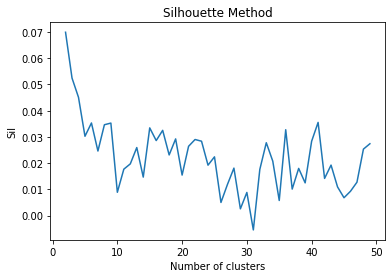

2:0.0698878272452846
3:0.05242611103194635
4:0.04508775966796104
5:0.030245557690823516
6:0.03531397039080623
7:0.024620242566525143
8:0.034638767138944704
9:0.03527139545115316
10:0.008899424584909988
11:0.017709675014002724
12:0.019724062991086606
13:0.02594566591110953
14:0.014689287191975401
15:0.03344036292187989
16:0.028605643273239785
17:0.032505273702738854
18:0.023130684893603367
19:0.029241426719488765
20:0.015459653580536211
21:0.026431056347780695
22:0.029015211525059422
23:0.028364799164952888
24:0.01923531782903744
25:0.022405132389759715
26:0.005026633939819339
27:0.01187305555758515
28:0.01811049694119386
29:0.002593847824800004
30:0.008835951172470801
31:-0.005440583475277357
32:0.017610330023852913
33:0.027783052714149235
34:0.02077040126498699
35:0.005778406744356242
36:0.03273918682870169
37:0.010120531897217792
38:0.017999157197080368
39:0.012487904833562762
40:0.028340380464406977
41:0.03552622600868878
42:0.0141852842744108
43:0.019258436420530597
44:0.0109579901

In [83]:
# Silhouette method to find the optimal number of clusters
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

sil = []

for k in range(2, 50):
  kmeans = KMeans(n_clusters = k).fit(em)  
  preds = kmeans.fit_predict(em)
  sil.append(silhouette_score(em, preds, metric = 'euclidean'))


plt.plot(range(2, 50), sil)
plt.title('Silhouette Method')
plt.xlabel('Number of clusters')
plt.ylabel('Sil')
plt.show()

for i in range(len(sil)):
 print(str(i+2) +":"+ str(sil[i]))

In [84]:
# Number of Clusters
k = 9

In [85]:
# K-means clustering
from sklearn.cluster import KMeans

km = KMeans(n_clusters = k)
%time km.fit(em)

Wall time: 1.99 s


## Clusters descriptions

In [124]:
def descriptions(name, labels):
    # Reactions
    txt[name] = labels
    print(txt.groupby(name).mean().round())
    print('\n')
        
    posts = { 'corpus': corpus, 'cluster': labels }
    posts = pd.DataFrame(posts)
    words_from_clusters = posts.groupby(['cluster'])['corpus'].apply(lambda x: "%s" % ' '.join(x))
    
    names = []
    for cluster in words_from_clusters:
            words_freq = FreqDist(cluster.split(' '))
            names.append(words_freq.most_common(1)[0][0])
            print('Cluster: ', cluster.title)
            print('Most popular words: ', words_freq.most_common(10))
            print('Total number of unique words: ', len(words_freq))
            print('\n')
            
    # Clusters cores
    cores = pd.DataFrame({'names':names})
    cores['shares'] = (posts.groupby(['cluster']).count()/len(labels)*100).round(2)
    print(cores)

In [146]:
descriptions('kmw2v', km.labels_.tolist())

        like  love  haha  wow  sad  angry
kmw2v                                    
0       92.0   7.0   4.0  1.0  5.0    7.0
1       48.0   1.0   4.0  1.0  2.0    6.0
2       72.0   2.0   3.0  1.0  4.0    3.0
3       94.0   3.0   5.0  1.0  5.0    5.0
4       15.0   1.0   2.0  0.0  0.0    0.0
5       22.0   1.0   9.0  1.0  1.0    5.0
6      199.0   6.0  62.0  3.0  6.0   24.0
7      116.0   7.0  11.0  2.0  2.0    8.0
8       14.0   0.0   2.0  0.0  0.0    1.0


Cluster:  <built-in method title of str object at 0x000002C98E223950>
Most popular words:  [('пандемія', 189), ('питання', 181), ('планета', 169), ('влад', 157), ('бізнес', 145), ('українець', 143), ('ситуація', 139), ('право', 138), ('епідемія', 129), ('вірус', 122)]
Total number of unique words:  7815


Cluster:  <built-in method title of str object at 0x000002C98D77C040>
Most popular words:  [('допомога', 300), ('здоров', 285), ('робот', 258), ('бізнес', 237), ('державний', 224), ('медичний', 210), ('охорона', 210), ('питання',

## W2V AgglomerativeClustering

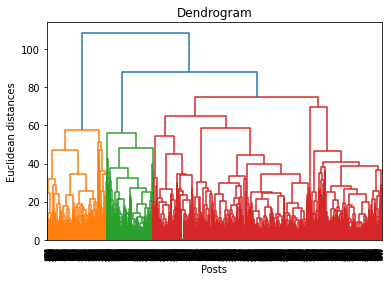

In [92]:
# Using the dendrogram to find the optimal number of clusters
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(em, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Posts')
plt.ylabel('Euclidean distances')
plt.show()

In [93]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = k, affinity = 'euclidean', linkage = 'ward').fit_predict(em)

In [147]:
descriptions('agw2v', hc)

        like  love  haha  wow  sad  angry  kmw2v
agw2v                                           
0       47.0   1.0   4.0  1.0  5.0    7.0    1.0
1       27.0   1.0   4.0  1.0  0.0    2.0    4.0
2       12.0   1.0   1.0  1.0  0.0    2.0    7.0
3      125.0   7.0   8.0  1.0  3.0    9.0    5.0
4      183.0   6.0  58.0  3.0  6.0   22.0    6.0
5       71.0   2.0   6.0  1.0  4.0    3.0    3.0
6       13.0   0.0   0.0  0.0  0.0    0.0    4.0
7       82.0   4.0   4.0  1.0  4.0    5.0    3.0
8       45.0   1.0  12.0  1.0  1.0    1.0    5.0


Cluster:  <built-in method title of str object at 0x000002C98E7366E0>
Most popular words:  [('бізнес', 188), ('економіка', 182), ('планета', 163), ('українець', 124), ('питання', 123), ('право', 114), ('пандемія', 112), ('великий', 111), ('ринок', 111), ('робот', 110)]
Total number of unique words:  7129


Cluster:  <built-in method title of str object at 0x000002C98E61F950>
Most popular words:  [('допомога', 496), ('державний', 317), ('захід', 299), ('пр

## MeanShift

In [98]:
from sklearn.cluster import MeanShift
mshift = MeanShift(bandwidth=22).fit(em)

In [148]:
descriptions('msw2v', mshift.labels_)

       like  love  haha  wow  sad  angry  kmw2v  agw2v
msw2v                                                 
0      71.0   3.0   5.0  1.0  3.0    5.0    3.0    4.0
1       1.0   0.0   0.0  0.0  0.0    0.0    5.0    8.0
2      10.0   0.0  63.0  1.0  9.0    4.0    5.0    8.0
3       1.0   0.0   0.0  0.0  0.0    0.0    3.0    3.0
4       9.0   0.0   0.0  1.0  0.0    0.0    0.0    0.0
5       4.0   1.0   5.0  0.0  0.0    1.0    5.0    8.0
6       0.0   0.0   0.0  0.0  0.0    0.0    0.0    2.0
7       9.0   0.0   0.0  0.0  0.0    0.0    8.0    2.0
8       3.0   0.0   0.0  0.0  0.0    0.0    7.0    2.0


Cluster:  <built-in method title of str object at 0x000002C98EEDE040>
Most popular words:  [('тест', 1004), ('допомога', 961), ('вакцина', 909), ('здоров', 882), ('питання', 877), ('робот', 850), ('вірус', 810), ('міністр', 803), ('захід', 786), ('обмеження', 783)]
Total number of unique words:  28644


Cluster:  <built-in method title of str object at 0x000002C99182FAB0>
Most popular words

## HDBSCAN

In [54]:
import hdbscan

hdb = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=8)
hdb.fit(em)

11

In [149]:
descriptions('hdbw2v', hdb.labels_)

         like  love  haha  wow   sad  angry  kmw2v  agw2v  msw2v
hdbw2v                                                          
-1       68.0   3.0   5.0  1.0   3.0    5.0    3.0    4.0    0.0
 0        1.0   0.0   0.0  0.0   0.0    0.0    8.0    2.0    0.0
 1        1.0   0.0   2.0  0.0   0.0    0.0    1.0    7.0    0.0
 2        8.0   0.0   5.0  2.0   8.0    3.0    2.0    5.0    0.0
 3        2.0   0.0   0.0  0.0   0.0    0.0    6.0    3.0    0.0
 4      199.0   5.0   0.0  0.0   1.0    0.0    7.0    3.0    0.0
 5        9.0   1.0   0.0  0.0   0.0    0.0    4.0    6.0    0.0
 6        8.0   0.0   0.0  0.0   0.0    0.0    8.0    1.0    0.0
 7       15.0   0.0   0.0  0.0   0.0    0.0    0.0    7.0    0.0
 8      193.0   4.0  13.0  2.0  11.0    8.0    4.0    5.0    0.0
 9        8.0   0.0   0.0  0.0   0.0    0.0    0.0    0.0    0.0


Cluster:  <built-in method title of str object at 0x000002C98EED2040>
Most popular words:  [('тест', 793), ('вакцина', 790), ('здоров', 745), ('допомога'

## UMAP

In [56]:
#!pip install umap-learn

In [57]:
import umap
mapper = umap.UMAP(n_neighbors=15,min_dist=0.15, n_components=2).fit(em)

In [58]:
#!pip install datashader
#!pip install bokeh 
#!pip install holoviews 
#!pip install scikit-image
#!pip install colorcet

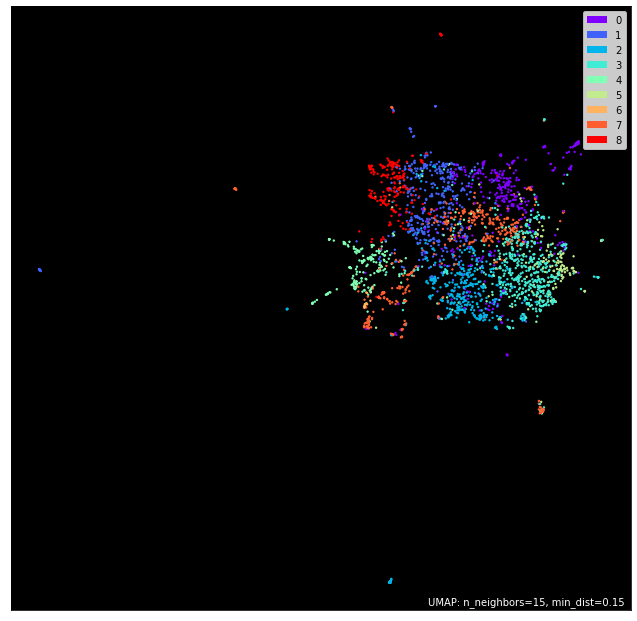

In [103]:
import umap.plot
umap.plot.points(mapper, labels=np.array(txt.w2v), theme='fire')
umap.plot.plt.show()

## UMAP+DBSCAN

In [60]:
reducer = umap.UMAP(n_neighbors = 15, min_dist = 0, n_epochs=50000)
X_umap = reducer.fit_transform(em)
umap_cl = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=7).fit(X_umap)

[-1 39  1 ... 46 39 -1]


In [150]:
descriptions('umapw2v', umap_cl.labels_)

          like  love  haha  wow   sad  angry  kmw2v  agw2v  msw2v  hdbw2v
umapw2v                                                                  
-1        53.0   2.0   3.0  1.0   2.0    3.0    3.0    4.0    0.0    -1.0
 0         1.0   0.0   2.0  0.0   0.0    0.0    1.0    7.0    0.0     1.0
 1        10.0   0.0   4.0  2.0   7.0    3.0    2.0    5.0    0.0     2.0
 2        91.0   1.0   4.0  0.0   0.0    2.0    6.0    6.0    0.0     3.0
 3       970.0  98.0  19.0  3.0   2.0   10.0    1.0    3.0    0.0    -1.0
...        ...   ...   ...  ...   ...    ...    ...    ...    ...     ...
 87       60.0   2.0   7.0  1.0   4.0    1.0    3.0    5.0    0.0    -1.0
 88        9.0   0.0   1.0  0.0   2.0    0.0    5.0    6.0    0.0    -1.0
 89       26.0   1.0   4.0  1.0   3.0    3.0    4.0    6.0    0.0    -1.0
 90      280.0   4.0  39.0  4.0  15.0   27.0    6.0    3.0    0.0     0.0
 91      152.0   1.0   3.0  1.0   4.0   19.0    3.0    3.0    0.0    -0.0

[93 rows x 10 columns]


Cluster:  <b

Cluster:  <built-in method title of str object at 0x000002C9C7A28010>
Most popular words:  [('турист', 94), ('травень', 89), ('кордон', 85), ('червень', 68), ('міністр', 63), ('туристичний', 54), ('іспанія', 54), ('туреччина', 47), ('туризм', 43), ('заявити', 40)]
Total number of unique words:  1670


Cluster:  <built-in method title of str object at 0x000002C9C7AC7EC0>
Most popular words:  [('цифровий', 48), ('медицина', 33), ('освіта', 30), ('послуга', 24), ('трансформація', 20), ('наука', 20), ('міністр', 19), ('цифровізація', 19), ('система', 18), ('повідомлення', 18)]
Total number of unique words:  1330


Cluster:  <built-in method title of str object at 0x000002C9C7AF5360>
Most popular words:  [('освіта', 74), ('навчання', 53), ('школа', 49), ('учень', 38), ('діти', 36), ('дистанційний', 26), ('вчитель', 26), ('освітній', 19), ('педагог', 17), ('навчатися', 15)]
Total number of unique words:  1065


Cluster:  <built-in method title of str object at 0x000002C9C76FFEA0>
Most popula

Cluster:  <built-in method title of str object at 0x000002C9C7595360>
Most popular words:  [('допомога', 157), ('працівник', 92), ('регіон', 59), ('підтримка', 57), ('червоний', 56), ('найманий', 54), ('гривня', 46), ('обмеження', 43), ('місцевий', 43), ('підприємець', 41)]
Total number of unique words:  684


Cluster:  <built-in method title of str object at 0x000002C9C796CD80>
Most popular words:  [('вони', 46), ('інстинкт', 44), ('частина', 39), ('зробити', 32), ('фізіологічно', 29), ('слово', 25), ('правильний', 23), ('особистий', 22), ('дівчина', 22), ('який', 22)]
Total number of unique words:  897


Cluster:  <built-in method title of str object at 0x000002C9C45D5620>
Most popular words:  [('індія', 30), ('гуманітарний', 16), ('допомога', 15), ('крим', 12), ('республіка', 10), ('херсонщина', 9), ('питання', 8), ('ситуація', 8), ('перти', 8), ('надання', 7)]
Total number of unique words:  440


Cluster:  <built-in method title of str object at 0x000002C9C77B3980>
Most popular wor

In [62]:
def plot_2d(X, label_list_cluster):
    plt.figure(figsize=(7, 7))
    plt.subplots_adjust(bottom=0.1)
    c = label_list_cluster
    plt.scatter(X[:, 0], X[:, 1], c=c, cmap='rainbow', label='True Position')
    plt.show()

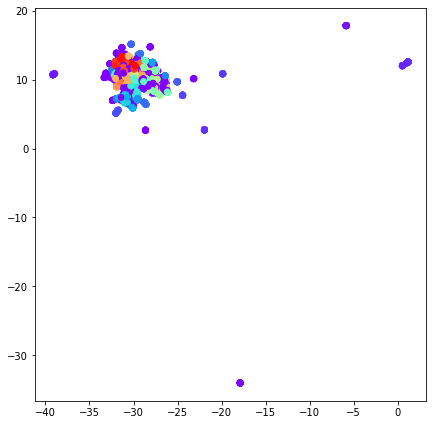

In [63]:
plot_2d(X_umap,umap_cl.labels_)

# Matching

In [138]:
# Importing prepared dataset

input = open('tfidf-clusters.pql', 'rb')
obj = pickle.load(input)
input.close()
txt_tfidf = obj['txt']

In [139]:
txt_tfidf

,text,like,love,haha,wow,sad,angry,kmeans,kmLDA,agLDA,hdb,umap
0,"Заходи (завдання), які виконані в зоні (районі...",2.0,0.0,0.0,0.0,0.0,0.0,0,0,1,-1,-1
1,Світова пандемія принесла невизначеність у сус...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,-1,8
2,За добу в Польщі померло понад 800 людей від к...,1.0,0.0,0.0,0.0,0.0,0.0,8,0,1,-1,8
3,"Мене часто питають, а як зробити інакше. Ось я...",1.0,3.0,0.0,0.0,0.0,0.0,3,0,1,-1,8
4,Президент України Володимир Зеленський підписа...,0.0,0.0,0.0,0.0,0.0,0.0,3,0,1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
2847,"очуміти ,нічому людей ані ковід, ані війна , а...",1.0,0.0,0.0,1.0,0.0,0.0,3,0,1,-1,8
2848,Зеленський і «Слуги народу» намагаються втюхат...,97.0,0.0,0.0,0.0,14.0,0.0,3,0,1,-1,8
2849,"У час, коли над Україною нависла загроза прямо...",52.0,2.0,0.0,0.0,0.0,0.0,1,0,1,-1,8
2850,Вчора під час ефіру на «Свободі слова» звернул...,160.0,7.0,0.0,0.0,1.0,2.0,1,0,1,-1,8


In [151]:
df = txt_tfidf.merge(txt, left_index=True, right_index=True)

,text_x,like_x,love_x,haha_x,wow_x,sad_x,angry_x,kmeans,kmLDA,agLDA,...,love_y,haha_y,wow_y,sad_y,angry_y,kmw2v,agw2v,msw2v,hdbw2v,umapw2v
0,"Заходи (завдання), які виконані в зоні (районі...",2.0,0.0,0.0,0.0,0.0,0.0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,1,7,0,8,-1
1,Світова пандемія принесла невизначеність у сус...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,7,7,0,-1,39
2,За добу в Польщі померло понад 800 людей від к...,1.0,0.0,0.0,0.0,0.0,0.0,8,0,1,...,0.0,0.0,0.0,0.0,0.0,4,5,0,-1,1
3,"Мене часто питають, а як зробити інакше. Ось я...",1.0,3.0,0.0,0.0,0.0,0.0,3,0,1,...,3.0,0.0,0.0,0.0,0.0,0,7,0,-1,62
4,Президент України Володимир Зеленський підписа...,0.0,0.0,0.0,0.0,0.0,0.0,3,0,1,...,0.0,0.0,0.0,0.0,0.0,8,1,0,-1,67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2847,"очуміти ,нічому людей ані ковід, ані війна , а...",1.0,0.0,0.0,1.0,0.0,0.0,3,0,1,...,0.0,0.0,1.0,0.0,0.0,7,0,0,-1,90
2848,Зеленський і «Слуги народу» намагаються втюхат...,97.0,0.0,0.0,0.0,14.0,0.0,3,0,1,...,0.0,0.0,0.0,14.0,0.0,2,7,0,-1,82
2849,"У час, коли над Україною нависла загроза прямо...",52.0,2.0,0.0,0.0,0.0,0.0,1,0,1,...,2.0,0.0,0.0,0.0,0.0,1,1,0,-1,46
2850,Вчора під час ефіру на «Свободі слова» звернул...,160.0,7.0,0.0,0.0,1.0,2.0,1,0,1,...,7.0,0.0,0.0,1.0,2.0,7,1,0,-1,39


In [152]:
df.drop(['text_x','like_x','love_x','haha_x','wow_x','sad_x','angry_x','text_y','like_y','love_y','haha_y','wow_y','sad_y','angry_y'], axis='columns', inplace=True)
df

,kmeans,kmLDA,agLDA,hdb,umap,kmw2v,agw2v,msw2v,hdbw2v,umapw2v
0,0,0,1,-1,-1,1,7,0,8,-1
1,1,0,0,-1,8,7,7,0,-1,39
2,8,0,1,-1,8,4,5,0,-1,1
3,3,0,1,-1,8,0,7,0,-1,62
4,3,0,1,-1,-1,8,1,0,-1,67
...,...,...,...,...,...,...,...,...,...,...
2847,3,0,1,-1,8,7,0,0,-1,90
2848,3,0,1,-1,8,2,7,0,-1,82
2849,1,0,1,-1,8,1,1,0,-1,46
2850,1,0,1,-1,8,7,1,0,-1,39


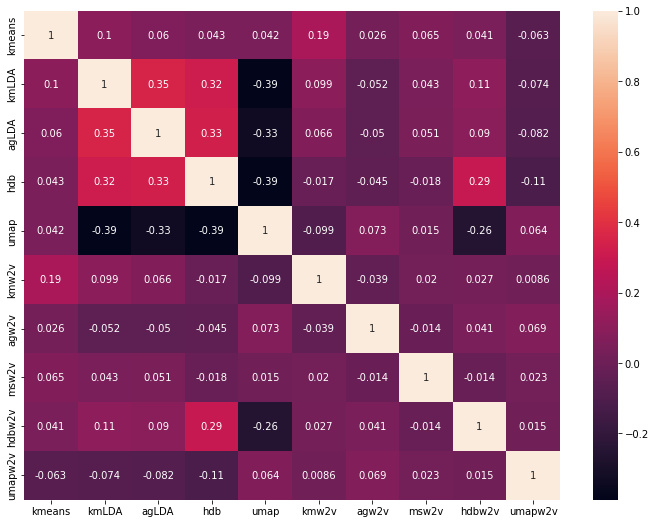

In [153]:
import seaborn as sns

corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, annot=True)
plt.show()

In [160]:
# Comparing Clustering Algorithms
from sklearn.metrics.cluster import adjusted_rand_score
adjusted_rand_score(np.array(df.umap),np.array(df.kmLDA)).round(2),adjusted_rand_score(np.array(df.umap),np.array(df.hdb)).round(2),adjusted_rand_score(np.array(df.hdbw2v),np.array(df.hdb)).round(2),adjusted_rand_score(np.array(df.hdbw2v),np.array(df.umap)).round(2)

(0.36, 0.32, 0.27, 0.22)